In [1]:
import sys,os,signal

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

root = './musicnet'

%matplotlib inline

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='2'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 4, 'pin_memory': True, 'worker_init_fn': worker_init}

m = 128
k = 500
d = 4096
window = 16384
stride = 512
regions = 1 + (window - d)//stride

In [ ]:
train_set = musicnet.MusicNet(root=root, train=True, download=True, window=window)#, pitch_shift=5, jitter=.1)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [ ]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [ ]:
wsin,wcos = create_filters(d,k)

with torch.cuda.device(0):
    wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
    wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
    
def init_weights(scale=0.):
    wscale = 0.
    with torch.cuda.device(0):
        beta = Variable(wscale*torch.rand([regions*k,m]).cuda(), requires_grad=True)
        betaavg = Variable(beta.data.clone(), requires_grad=False)
    return (beta,), (betaavg,)

def forward(x, beta):
    zx = conv1d(x[:,None,:], wsin_var, stride=stride).pow(2) \
       + conv1d(x[:,None,:], wcos_var, stride=stride).pow(2)
    return torch.mm(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],regions*k), beta)

def L(y_hat, y, beta):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.# + .01*torch.mean(beta.pow(2.))

# Train the model

In [ ]:
weights, averages = init_weights()
loss_history = []
avgp_history = []

In [8]:
avg = .9998
optimizer = torch.optim.SGD(weights, lr=0.000001, momentum=.95)

try:
    with train_set, test_set:
        print('square loss\tavg prec\ttime\t\tutime')
        for epoch in range(50):
            t = time()
            for i, (x, y) in enumerate(train_loader):
                optimizer.zero_grad()
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(forward(x,*weights),y,*weights)
                loss.backward()
                optimizer.step()

                for w,wavg in zip(weights, averages):
                    wavg.data.copy_(avg*wavg.data + (1.-avg)*w.data)

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            for i, (x, y) in enumerate(test_loader):
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                yhatvar = forward(x,*averages)
                loss += L(yhatvar,y,*averages).item()
                yground[i*batch_size:(i+1)*batch_size,:] = y.data
                yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            print('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

square loss	avg prec	time		utime
0.986567	0.621219	21.564085	7.679609
0.873448	0.632721	20.905450	7.602950
0.801929	0.642820	21.002190	7.718445
0.755993	0.647780	20.141469	6.784245
0.725851	0.652447	15.806879	5.965170
0.708052	0.652070	15.693962	5.983294
0.698663	0.659720	15.605959	5.893206
0.687680	0.654076	15.953896	6.123796
0.685857	0.655815	15.847305	6.049842
0.683606	0.658103	15.850273	6.177502
0.679673	0.658590	16.012017	6.008902
0.682207	0.661769	15.844891	6.028954
0.686033	0.659652	15.902245	6.002839
0.685517	0.658726	15.924718	6.065756
0.679789	0.662992	15.813283	6.038318
0.687733	0.663217	15.804095	5.974814
0.685760	0.663800	15.913707	6.051164
0.683087	0.663003	17.786858	7.902777
0.684517	0.664137	20.905091	7.825500
0.687459	0.663850	21.013634	7.956584
0.685935	0.665258	21.023695	8.066811
0.686206	0.663799	18.233878	5.997908
0.686560	0.668035	17.938216	7.876208
0.687783	0.665997	21.035795	8.010172
0.688919	0.665068	20.944970	8.011961
0.688473	0.663751	19.169249	6.846789
0.684

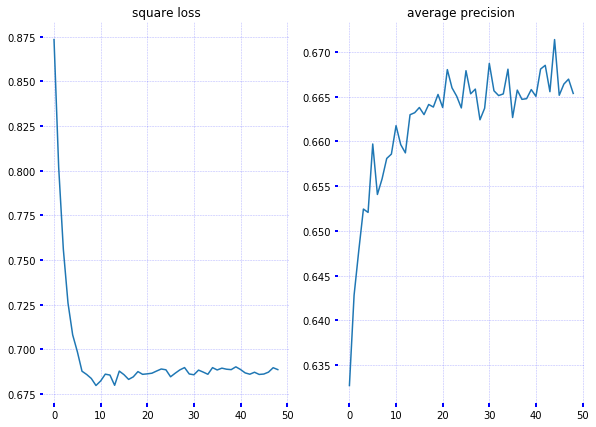

In [9]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])